# Imports

In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import datetime
from datetime import date, timedelta, datetime
from google.cloud import storage
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import joblib
#from matplotlib_venn import venn3

from datetime import datetime
from sklearn.preprocessing import StandardScaler

import pickle

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [3]:
query = """
SELECT 
visitor_visit_id,
array_agg(itemId) items_id,
array_agg(v2ProductName) items_name,
array_agg(v2ProductCategory) v2ProductCategory
from 
`mightyhive-data-science-poc.ds_ezemeli.recommender_vea_full_raw`
where rating = 5
group by visitor_visit_id
"""

In [4]:
client = bigquery.Client()
df = client.query(query).to_dataframe()
df.to_parquet("data/recommender_associetion_rules.parquet", index=False)

In [5]:
df.shape

(35971, 4)

In [6]:
df.head()

,visitor_visit_id,items_id,items_name,v2ProductCategory
0,4682575112413999464-3,"[12191, 100047729, 46236, 51363, 46243, 6008, ...",[Toalla Higiénica NOSOTRAS Buenas Noches Mayor...,"[Cuidado Personal y Salud, Carnes, aves y pesc..."
1,701170717086203454-141,"[31112, 51380, 48747, 33005, 53243, 7794]","[Filete de Trucha Fresco, Pasta Dental AQUAFRE...","[Carnes, aves y pescados, Cuidado Personal y S..."
2,8245964484084846073-47,"[11741, 46684, 7327, 10696, 6314, 156, 3056, 1...",[Filete de Pechuga de Pollo Oriental REDONDOS ...,"[Carnes, aves y pescados, Congelados, Bebidas,..."
3,477653686965823739-1,"[30479, 12111]","[Café NESCAFÉ Tradición Frasco 200g, Café Inst...","[Desayunos, Desayunos]"
4,7593678983271530528-9,"[32954, 125, 9926, 2958, 8862, 50543, 13562, 5...",[Toallitas Húmedas HUGGIES Limpieza Efectiva P...,"[Cuidado del Bebé, Quesos y Fiambres, Abarrote..."


# Cantidades

In [7]:
df['transacction_len'] = df['items_id'].apply(lambda x: len(x))
df.head(1)

,visitor_visit_id,items_id,items_name,v2ProductCategory,transacction_len
0,4682575112413999464-3,"[12191, 100047729, 46236, 51363, 46243, 6008, ...",[Toalla Higiénica NOSOTRAS Buenas Noches Mayor...,"[Cuidado Personal y Salud, Carnes, aves y pesc...",15


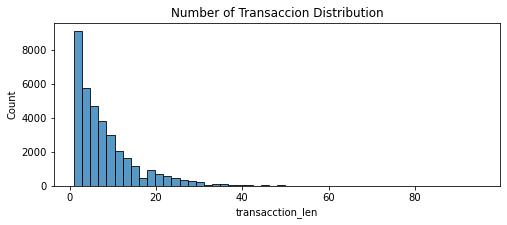

In [8]:
# Cantidad de productos comprados por Compra

plt.figure(figsize=(8,3))
sns.histplot(df['transacction_len'], bins=50)
plt.title("Number of Transaccion Distribution")
plt.show()

In [9]:
# Aplanamos la lista de compras
compras_totales = []
for i in df.items_name:
      for j in i:
        compras_totales.append(j)
        
# Mostramos la lista de los Productos mas vendidos
n_productos = 10
compras_totales = pd.DataFrame(compras_totales, columns=['elementos'])
productos_mas_vendidos = compras_totales.elementos.value_counts()[:n_productos]
productos_mas_vendidos

Huevos de Gallina BELL'S Pardos Bandeja 15un                 1754
Huevos Pardos LA CALERA Paquete 30un                         1672
Carne Molida Light de Res Empacada al vacío EL BUEN CORTE    1332
Carne Molida de Res Empacada al vacío EL BUEN CORTE          1234
Arroz Extra COSTEÑO Bolsa 5Kg                                1072
Aceite Vegetal PRIMOR Premium Botella 1L                     1065
Pan de Molde Blanco BIMBO Extra Grande Bolsa 750g             980
Huevos de Gallina LA CALERA de Corral Bandeja 12un            977
Bisteck de Res Empacada al vacío                              968
Cerveza STELLA ARTOIS Premium Botella 330ml 6 Pack            909
Name: elementos, dtype: int64

In [44]:
# GENERAMOS LA LISTA DE PRODUCTOS TOTAL

#Elegimos la cantidad de palabras del corpus (texto)
n_words = 1
product_id = []
product_list_name = []
product_category = []

for i in range(df.items_id.shape[0]):
    for j,k,t in zip(df.items_id[i], df.items_name[i], df.v2ProductCategory[i]):
        
        # Naming convention needed (tomamos solo K palabras de cada producto)
        k = " ".join([x.lower() for x in k.split()[:n_words]])
        
        if j not in product_id and k not in product_list_name:
            product_id.append(j)
            product_list_name.append(k)
            product_category.append(t)  
# Alerta fin proceso            
Audio(beep, rate=10000, autoplay=True)

#30497 Limón Ácido x Kg

## Disclaimer
- Aca hay un proceso de Feature Ingenieering donde estamos tomando unicamente tipos de productos y bajando cardinalidad - Ejemplo "vino Malbec" == "vino Torrontes"

In [45]:
df_product = pd.DataFrame(np.array([product_id, product_list_name, product_category]).T, columns=['item_id', 'item_name', 'item_category'])

In [49]:
df_product.shape

(1072, 3)

In [46]:
df_product.head()

,item_id,item_name,item_category
0,12191,toalla,Cuidado Personal y Salud
1,100047729,hígado,"Carnes, aves y pescados"
2,46236,paños,Limpieza
3,51363,toallitas,Limpieza
4,46243,trapeador,Limpieza


In [47]:
df_product[df_product['item_name']=='vino']

,item_id,item_name,item_category
106,5634,vino,Bebidas


In [48]:
df_product.sample(5)

,item_id,item_name,item_category
360,810,new,"Carnes, aves y pescados"
869,100089290,canasta,Abarrotes
741,5947,limpiadora,Cuidado Personal y Salud
910,35726,aro,Bazar
777,52158,green,Abarrotes


In [121]:
#Evaluamos la cantidad de Categorias
df_product.groupby("item_category").count().sort_values(by="item_id", ascending=False).T

item_category,Abarrotes,Limpieza,Decohogar,"Carnes, aves y pescados",Quesos y Fiambres,Bebidas,Cuidado Personal,"Panadería, Pastelería y Comidas","Carnes, Aves y Pescados",Cuidado Personal y Salud,Congelados,Panadería y Pastelería,Electrohogar,Electro,Hogar y Colchones,Desayunos,Tecnología,"Panadería, Pastelería y Comidas Preparadas",Lácteos y Huevos,Bazar,Juguetería,Bebé e Infantil,Juguetes y Juegos,Mascotas,Librería,Pollo Rostizado y Comidas Preparadas,Librería y Oficina,Deportes,Mejoramiento del Hogar,Cuidado del Bebé,Muebles,Dormitorio,Packs,Basura
item_id,261,69,60,50,49,47,47,43,43,38,34,34,30,29,26,26,23,21,15,15,14,14,13,11,9,9,8,7,7,7,6,5,1,1
item_name,261,69,60,50,49,47,47,43,43,38,34,34,30,29,26,26,23,21,15,15,14,14,13,11,9,9,8,7,7,7,6,5,1,1


In [50]:
# VECTORIZAMOS 
transaction_matrix = []

# recorremos todas las transacciones
for i in range(df.items_id.shape[0]):
    #Creamos un vector Zeros con el largo de la cantidad de productos
    vector = np.zeros(len(df_product))
    for j in df.items_name[i]:
       
        #Aplicamos misma transformacion ("Naming Convention")
        j = " ".join([x.lower() for x in j.split()[:n_words]])
        try:
        # Si el producto se encuentra en la transaccion Ingresamos un 1 en el vector.
            indice = product_list_name.index(j)
            vector[indice] = 1
        except ValueError:
            pass
    transaction_matrix.append(vector)
Audio(beep, rate=5000, autoplay=True)

In [51]:
#transformamos la lista en array
transaction_matrix = np.array(transaction_matrix)

In [52]:
transaction_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
# Calculamos el suport de cada producto hardcodeado
support = np.sum(transaction_matrix, axis=0)/transaction_matrix.shape[0] 

In [54]:
#Creamos un Dataframe para unir producto con frecuencia
support_df = pd.DataFrame(data = [product_list_name,support],)

In [55]:
# Trasponemos el dataframe y renombramos las columnas
support_df = support_df.T.rename(columns={0:'Producto',1: 'Soporte'})

In [56]:
#Ordenamos de mayor a menor en funcion del soporte
support_df.sort_values(by='Soporte', ascending=False, inplace=True, ignore_index=True)

In [59]:
support_df.head(5)

,Producto,Soporte
0,pan,0.25009
1,queso,0.237719
2,huevos,0.182425
3,leche,0.181563
4,vino,0.162186


In [61]:
support_df.sample(5)

,Producto,Soporte
992,bañera,0.000028
1027,analgésico,0.000028
501,desmaquillantes,0.000639
1056,espatulón,0.000028
396,pastelito,0.000973


In [62]:
# Verificamos que tenemos los 14287 items y sus frecuencias
support_df.shape

(1072, 2)

In [63]:
# !pip install mlxtend

In [64]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [65]:
transaction_matrix.shape

(35971, 1072)

In [66]:
#convertimos la matriz en df con el indice como lista de productos
matrix_df = pd.DataFrame(data = transaction_matrix.T,index=product_id)

In [67]:
# Transponemos la matriz para que la funcion la pueda tomar como argumento
matrix_df = matrix_df.T

In [68]:
#Aplicamos el algoritmo A priori para limitar las Reglas
frequent_itemsets = apriori(matrix_df, min_support=0.01, use_colnames=True)
frequent_itemsets.shape

(217, 2)

In [69]:
#ordenamos el output en funcion de los valores de soporte -- Verificamos que nos da los mismos valores que la version hardcodeada
frequent_itemsets.sort_values(by='support', ascending=False)[:5]

,support,itemsets
8,0.250090,(7794)
14,0.237719,(6026)
1,0.182425,(6008)
4,0.181563,(3350)
44,0.162186,(5634)


In [107]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.01,)
rules.shape

(496, 9)

In [108]:
rules.head(5).sort_values(by='confidence' ,ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(3350),(6008),0.181563,0.182425,0.074477,0.410198,2.248585,0.041355,1.386185
2,(52692),(6008),0.138028,0.182425,0.053293,0.386103,2.116504,0.028113,1.331779
0,(37199),(6008),0.136137,0.182425,0.050680,0.372269,2.040670,0.025845,1.302429
3,(6008),(52692),0.182425,0.138028,0.053293,0.292137,2.116504,0.028113,1.217710
1,(6008),(37199),0.182425,0.136137,0.050680,0.277812,2.040670,0.025845,1.196173


# Testeamos las reglas creadas

In [109]:
rules['antecedents_no_frozen'] = rules['antecedents'].apply(lambda x: list(x)[0]).astype("unicode")
rules['consequents_no_frozen'] = rules['consequents'].apply(lambda x: list(x)[0]).astype("unicode")

In [110]:
rules['antecedents_no_frozen_by_name'] = rules['antecedents_no_frozen'].apply(lambda x: df_product[df_product['item_id']==x]['item_name'].iloc[0])
rules['consequents_no_frozen_by_name'] = rules['consequents_no_frozen'].apply(lambda x: df_product[df_product['item_id']==x]['item_name'].iloc[0])

In [111]:
rules[['antecedents_no_frozen_by_name','consequents_no_frozen_by_name']].value_counts()[:2]

antecedents_no_frozen_by_name  consequents_no_frozen_by_name
pan                            leche                            16
leche                          pan                              16
dtype: int64

In [112]:
random_index = np.random.randint(rules.shape[0])
testing_item = rules['antecedents_no_frozen'][random_index]
print(f"Testing ITEM ID: {testing_item}")

Testing ITEM ID: 6008


In [113]:
df_product[df_product['item_id']==testing_item]

,item_id,item_name,item_category
5,6008,huevos,Lácteos y Huevos


In [114]:
# Ejemplo de "Consulta" al Modelo de Recomendacion
consulta = rules['consequents'][rules['antecedents'] == frozenset({testing_item})][1:6]


In [115]:
for i in list(consulta):
    element = str(list(i)[0])
    print(df_product[df_product['item_id']==element]['item_name'].iloc[0])

filete
leche
galletas
pan
mantequilla


In [118]:
def make_recommendation():
    random_index = np.random.randint(rules.shape[0])
    testing_item = rules['antecedents_no_frozen'][random_index]
    item_name = df_product[df_product['item_id']==testing_item]['item_name']
    print(100*"#")
    print(item_name)
    print(100*"#")
    consulta = rules['consequents'][rules['antecedents'] == frozenset({testing_item})][1:6]
    for i in list(consulta):
        element = str(list(i)[0])
        print(df_product[df_product['item_id']==element]['item_name'].iloc[0])
    

In [120]:
make_recommendation()

####################################################################################################
23    mantequilla
Name: item_name, dtype: object
####################################################################################################
leche
pan
yogurt
queso
pan


# V2 - 
USANDO transformer de la Libreria 

In [269]:
# import pandas as pd
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

In [279]:
# dataset = df['items_id'].copy()

In [282]:
# te = TransactionEncoder()
# te_ary = te.fit(dataset).transform(dataset)
# df2 = pd.DataFrame(te_ary, columns=te.columns_)

# frequent_itemsets = fpgrowth(df2, min_support=0.0006, use_colnames=True)

In [283]:
frequent_itemsets

,support,itemsets
0,0.002585,(33135)
1,0.001473,(6951)
2,0.001084,(14328)
3,0.001056,(100085726)
4,0.000695,(13027)
...,...,...
5471,0.000667,"(263, 1168)"
5472,0.000612,"(9053, 263)"
5473,0.000723,"(52607, 52604)"
5474,0.000751,"(1168, 9299)"
